In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.cn1 = nn.Conv2d(1, 16, 3)
    self.cn2 = nn.Conv2d(16, 32, 3)
    self.dp1 = nn.Dropout2d(0.1)
    self.dp2 = nn.Dropout2d(0.2)
    self.fc1 = nn.Linear(4608, 64) # 4068 = 12 x 12 x 32
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.relu(self.cn1(x))
    x = F.relu(self.cn2(x))
    x = F.max_pool2d(x, 2)
    x = self.dp1(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dp2(x)
    x = self.fc2(x)
    op = F.log_softmax(x, dim=1)
    return op

In [ ]:
def train(model, device, train_dataloader, optim, epoch):
  model.train()
  for b_i, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    pred_prob = model(X)
    loss = F.nll_loss(pred_prob, y)
    pred = (pred_prob.argmax(-1) == y).float().mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if b_i % 200 == 0:
      print(f'Epoch = {epoch}, step = {b_i}, train_loss = {loss.item():.3f}, train_acc = {pred.item():.3f}')

In [ ]:
def test(model, device, test_dataloader):
  model.eval()
  loss = 0
  success = 0

  with torch.no_grad():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      pred_prob = model(X)
      loss += F.nll_loss(pred_prob, y).item()
      success += (pred_prob.argmax(-1) == y).float().mean().item()

    avg_loss = loss / len(test_dataloader)
    avg_success = success / len(test_dataloader)
    print(f"Test loss = {avg_loss:.3f}, Test acc = {avg_success:.3f}")

In [ ]:
path = './data'

train_dataloader = DataLoader(
    datasets.MNIST(path, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(0.13, 0.3069)
                   ])),
                    batch_size=32, shuffle=True
)

test_dataloader = DataLoader(
    datasets.MNIST(path, train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(0.13, 0.3069)
                   ])),
                    batch_size=32, shuffle=False
)

In [ ]:
model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.5)

In [ ]:
for epoch in range(1, 10):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch = 1, step = 0, train_loss = 2.287, train_acc = 0.125
Epoch = 1, step = 200, train_loss = 0.766, train_acc = 0.781
Epoch = 1, step = 400, train_loss = 0.146, train_acc = 0.906
Epoch = 1, step = 600, train_loss = 0.140, train_acc = 0.938
Epoch = 1, step = 800, train_loss = 0.886, train_acc = 0.844
Epoch = 1, step = 1000, train_loss = 0.241, train_acc = 0.875
Epoch = 1, step = 1200, train_loss = 0.428, train_acc = 0.906
Epoch = 1, step = 1400, train_loss = 0.159, train_acc = 0.938
Epoch = 1, step = 1600, train_loss = 0.397, train_acc = 0.906
Epoch = 1, step = 1800, train_loss = 0.906, train_acc = 0.812
Test loss = 0.186, Test acc = 0.949
Epoch = 2, step = 0, train_loss = 0.757, train_acc = 0.781
Epoch = 2, step = 200, train_loss = 0.113, train_acc = 0.969
Epoch = 2, step = 400, train_loss = 0.079, train_acc = 0.969
Epoch = 2, step = 600, train_loss = 0.103, train_acc = 0.969
Epoch = 2, step = 800, train_loss = 0.177, train_acc = 0.969
Epoch = 2, step = 1000, train_loss = 0.167, trai

In [ ]:
dict(model.named_parameters()).keys()

dict_keys(['cn1.weight', 'cn1.bias', 'cn2.weight', 'cn2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [ ]:
model_children_list = list(model.children())
display(model_children_list)

[Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)),
 Dropout2d(p=0.1, inplace=False),
 Dropout2d(p=0.2, inplace=False),
 Linear(in_features=4608, out_features=64, bias=True),
 Linear(in_features=64, out_features=10, bias=True)]

In [ ]:
convolutional_layers = []
model_parameters = []

In [ ]:
for i in range(len(model_children_list)):
  if type(model_children_list[i]) == nn.Conv2d:
    model_parameters.append(model_children_list[i].weight)
    convolutional_layers.append(model_children_list[i])

In [ ]:
display(convolutional_layers)
print(model_parameters[0].shape)
print(model_parameters[1].shape)

[Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))]

torch.Size([16, 1, 3, 3])
torch.Size([32, 16, 3, 3])


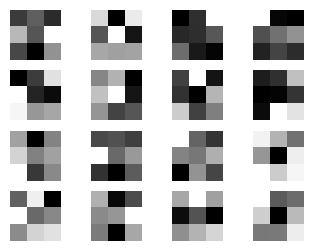

In [ ]:
plt.figure(figsize=(4, 3))
for i, flt in enumerate(model_parameters[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(flt[0].cpu().detach().numpy(), cmap='gray')
  plt.axis('off')
plt.show()

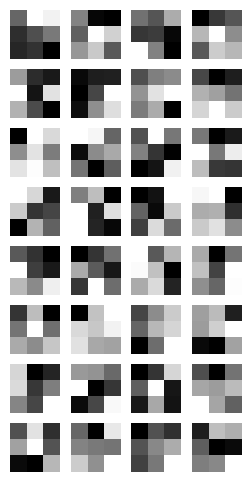

In [ ]:
plt.figure(figsize=(3, 6))
for i, flt in enumerate(model_parameters[1]):
  plt.subplot(8, 4, i+1)
  plt.imshow(flt[0].cpu().detach().numpy(), cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
b_i, (sample_data, sample_targets) = next(enumerate(test_dataloader))

In [ ]:
sample_data = sample_data.to(device)
print(sample_data.shape)

torch.Size([32, 1, 28, 28])


In [ ]:
print(convolutional_layers[0])
per_layers_result = [convolutional_layers[0](sample_data)]
print(per_layers_result[0].shape)

Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 16, 26, 26])


In [ ]:
for i in range(1, len(convolutional_layers)):
  per_layers_result.append(convolutional_layers[i](per_layers_result[-1]))

In [ ]:
print(len(per_layers_result))
print(per_layers_result[0].shape)
print(per_layers_result[1].shape)

2
torch.Size([32, 16, 26, 26])
torch.Size([32, 32, 24, 24])


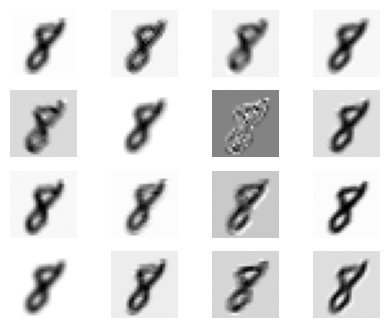

In [ ]:
idx = np.random.randint(0, per_layers_result[0].shape[0])

plt.figure(figsize=(5, 4))
layer_visualisation = per_layers_result[0][idx].data

for i, flt in enumerate(layer_visualisation):
  plt.subplot(4, 4, i+1)
  plt.imshow(flt.cpu().detach().numpy(), cmap='gray')
  plt.axis('off')
plt.show()

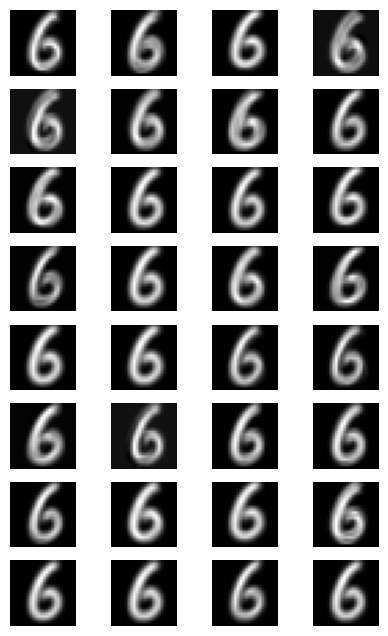

In [ ]:
idx = np.random.randint(0, per_layers_result[1].shape[0])

plt.figure(figsize=(5, 8))
layer_visualisation = per_layers_result[1][idx].data

for i, flt in enumerate(layer_visualisation):
  plt.subplot(8, 4, i+1)
  plt.imshow(flt.cpu().detach().numpy(), cmap='gray')
  plt.axis('off')
plt.show()

# 의료 영상 AI

In [3]:
!pip install -Uqq pydicom ipdb torchmetrics pytorch_lightning

In [4]:
import os
import glob
import ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import pydicom
import cv2
from tqdm.notebook import tqdm

In [5]:
root = "/content/drive/MyDrive/AI_application/pn_data_n1000/"
# root = "./pn_data_n1000/"

labels = pd.read_csv(root + "stage_2_train_labels.csv")
print("shape = ", labels.shape)
labels.head(6)

shape =  (30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [6]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")
print("shape = ", labels.shape)
labels.head()

shape =  (26684, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [7]:
ROOT_PATH = Path(root + "stage_2_train_images")
SAVE_PATH = Path(root + "Processed")
print(ROOT_PATH)
print(SAVE_PATH)

/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images
/content/drive/MyDrive/AI_application/pn_data_n1000/Processed


### Chest X-ray images

In [8]:
c = 0
image_list = []
target_list = []
while len(image_list) <= 8:
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    try:
        dcm = pydicom.dcmread(dcm_path).pixel_array
        image_list.append(dcm_path)
        target_list.append(labels.Target.iloc[c])
        c += 1
    except:
        c +=1
display("image list = \n", image_list)
display("target_list = \n", target_list)

'image list = \n'

[PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00a85be6-6eb0-421d-8acf-ff2dc0007e8a.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00aecb01-a116-45a2-956c-08d2fa55433f.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00c0b293-48e7-4e16-ac76-9269ba535a62.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00f08de1-517e-4652-a04f-d1dc9ee48593.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/00f87de5-5fe0-4921-93ea-914d7e683266.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/01a4059c-22f7-4f51-8a27-50aff0b3aeb3.dcm'),
 PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images/01a5594f-e5d

'target_list = \n'

[np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1)]

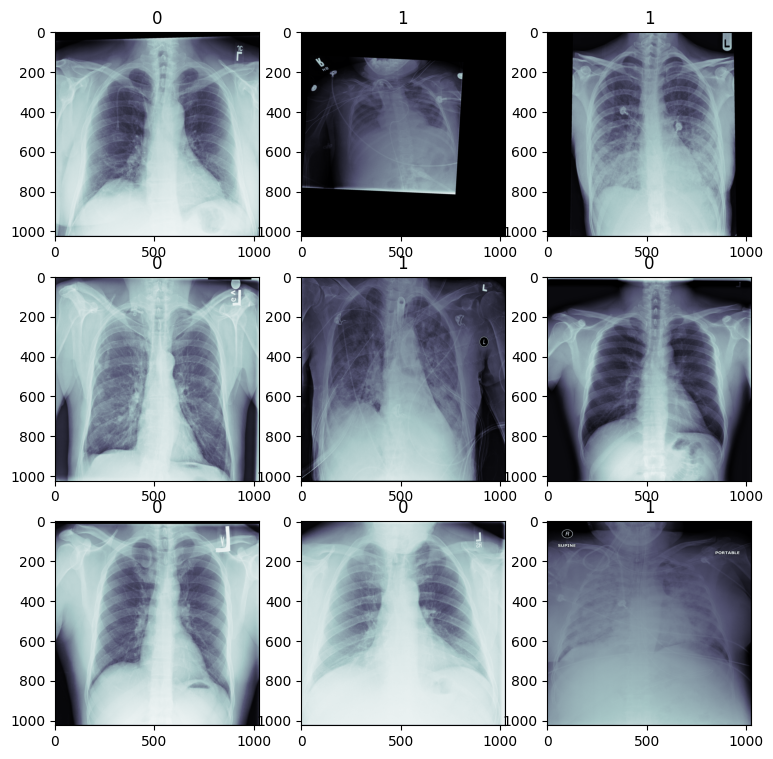

In [9]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
for i in range(9):
    row, col = divmod(i, 3)
    dcm = pydicom.dcmread(image_list[i]).pixel_array

    label = target_list[i]

    axis[row, col].imshow(dcm, cmap="bone")
    axis[row, col].set_title(label)

### Dicom Reading

In [10]:
ROOT_PATH

PosixPath('/content/drive/MyDrive/AI_application/pn_data_n1000/stage_2_train_images')

In [11]:
lentrain = len(os.listdir(ROOT_PATH)) # ROOT_PATH = pn_data_n1000\stage_2_train_images
print("train number = ", lentrain)

lentest = len(os.listdir(root + "/stage_2_test_images/"))
print("test number = ", lentest)

train number =  1000
test number =  100


In [12]:
lentrain = 800

In [13]:
import os
sums = 0
sums_squared = 0
count = 0
# ipdb.set_trace()
for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

    # if not os.path.isdir(dcm_path):
    #   print("I do not have this file")
    # Read the dicom file with pydicom and standardize the array
    if os.path.exists(dcm_path):
      dcm = pydicom.dcmread(dcm_path).pixel_array / 255

      # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
      # Let's use a shape of 224x224
      # In order to use less space when storing the image we convert it to float16
      dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

      # Retrieve the corresponding label
      label = labels.Target.iloc[c]

      # 4/5 train split, 1/5 val split
      train_or_val = "train" if count < lentrain else "val"

      current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
      current_save_path.mkdir(parents=True, exist_ok=True)
      np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory

      normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
      # if train_or_val == "train":  # Only use train data to compute dataset statistics
      #     sums += np.sum(dcm_array) / normalizer
      #     sums_squared += (np.power(dcm_array, 2).sum()) / normalizer
      count += 1


  0%|          | 0/26684 [00:00<?, ?it/s]

In [14]:
print(len(os.listdir(root + "Processed/train/0")))
print(len(os.listdir(root + "Processed/train/1")))

print(len(os.listdir(root + "Processed/val/0")))
print(len(os.listdir(root + "Processed/val/1")))

527
273
142
58


### Mean and Std

In [15]:
print(os.path.join(SAVE_PATH, "train/**/*.npy"))
print(len(glob.glob(os.path.join(SAVE_PATH, "train/**/*.npy"))))

/content/drive/MyDrive/AI_application/pn_data_n1000/Processed/train/**/*.npy
800


In [16]:
sums = 0
sums_squared = 0

for files in tqdm(glob.glob(os.path.join(SAVE_PATH, "train/**/*.npy"))):
  dcm_array = np.load(files)
  # Create the path to the dcm file
  normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
  sums += np.sum(dcm_array) / normalizer
  sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

  0%|          | 0/800 [00:00<?, ?it/s]

In [17]:
mean = sums / lentrain
std = np.sqrt(sums_squared / lentrain - (mean**2))

print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.494384765625, STD: 0.239013671875


### Training

In [18]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(),  # Convert numpy array to tensor
                            transforms.Normalize(0.097, 0.241),  # Use mean and std from preprocessing notebook
                            transforms.RandomAffine( # Data Augmentation
                                degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                            transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
                            ])

val_transforms = transforms.Compose([
                            transforms.ToTensor(),  # Convert numpy array to tensor
                            transforms.Normalize(0.097, 0.241),  # Use mean and std from preprocessing notebook
                            ])

In [19]:
def load_file(path):
    return np.load(path).astype(np.float32)

# PyTorch dataset class that expects a folder structure where each subfolder represents a class.
# More generic than ImageFolder
# Can be used for any dataset type, not just images (e.g., audio, text, numpy files).
# Requires a custom loader function to specify how the data should be read.
# Labels are still inferred from folder names, similar to ImageFolder
os.path.join(SAVE_PATH)
train_dataset = datasets.DatasetFolder(root = os.path.join(SAVE_PATH, "train"),
                                        loader=load_file,
                                        extensions="npy",
                                        transform=train_transforms)

val_dataset = datasets.DatasetFolder(root = os.path.join(SAVE_PATH, "val"),
                                       loader=load_file,
                                       extensions="npy",
                                       transform=val_transforms)

###  Augmented train images

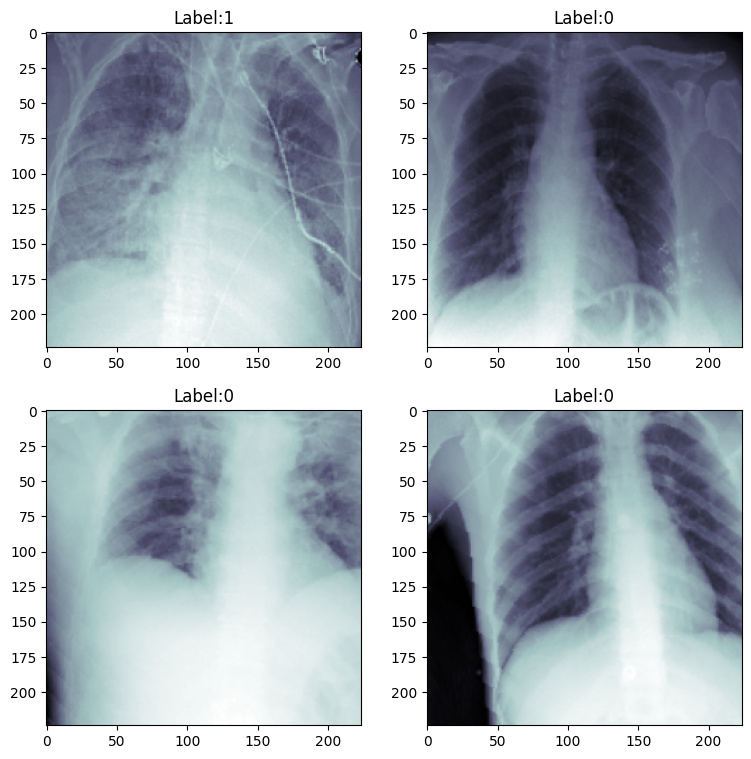

In [20]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 800)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [21]:
batch_size = 64 #TODO
# num_workers = 4#TODO

train_loader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        # num_workers=num_workers,
                        shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        # num_workers=num_workers,
                        # persistent_workers=True,
                        shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")
print(f"There are {len(train_loader)} train batches and {len(val_loader)} val batches")


There are 800 train images and 200 val images
There are 13 train batches and 4 val batches


In [22]:
print(np.unique(train_dataset.targets, return_counts=True))
print(np.unique(val_dataset.targets, return_counts=True))
train_dataset[0][0].shape

(array([0, 1]), array([527, 273]))
(array([0, 1]), array([142,  58]))


torch.Size([1, 224, 224])

### Model building

In [23]:
weigths = models.ResNet18_Weights.IMAGENET1K_V1
resnet18 = models.resnet18(weights = weigths)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
class PneumoniaModel(nn.Module):
    def __init__(self, weight=1):
        super().__init__()

        weigths = models.ResNet18_Weights.IMAGENET1K_V1
        self.model = models.resnet18(weights = weigths)
        for param in self.model.parameters():
            param.requires_grad = False
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = nn.Linear(in_features=512, out_features=1)

        # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        # self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))


    def forward(self, data): #needs to compute output from the resnet and return prediction
        pred = self.model(data)
        return pred

model = PneumoniaModel().to(device)  # Instanciate the model
# model.model.conv1.weight

In [25]:
# 학습률
lr = 1e-4
weight = 2
# 손실 함수 정의
# handling class imbalance in binary classification tasks.
# pos_weight를 device에 맞게 이동
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight])).to(device)

# 파라미터 수정 대상을 최종 노드로 제한
optimizer = optim.Adam(model.parameters(), lr=lr)
# step_size = 3
# gamma = 0.3
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [26]:
# PYTORCH_CUDA_ALLOC_CONF=expandable_segments
# torch.cuda.empty_cache()
# 반복 횟수

num_epochs = 10

# 평가 결과 기록
history = []
acc = 0.0
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0

    model.train()
    print("training")
    for X, Y in tqdm(train_loader):

        data, target = X.to(device), Y.to(device) # X shape = torch.Size([64, 1, 224, 224]), target shape = torch.Size([64])
        output = model(data)
        # output shape = torch.Size([64, 1])
        loss = criterion(output.squeeze(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.where(output.squeeze() < 0.0, 0, 1)
        train_loss += loss.item()
        train_acc += (predicted == target).float().mean().item()

    # scheduler.step()
    avg_loss = train_loss/len(train_loader)
    avg_acc = train_acc/len(train_loader)
    print(f"epoch = {epoch}, avg_train_loss = {avg_loss}, avg_train_acc = {avg_acc}")


    model.eval()
    print("validating")
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for X_, Y_ in tqdm(val_loader):
            data_, target_ = X_.to(device), Y_.to(device)
            output_ = model(data_)
            val_loss = criterion(output_.squeeze(), target_.float())
            predicted_ = torch.where(output_.squeeze() < 0.0, 0, 1)
            val_loss += val_loss.item()
            val_acc += (predicted_ == target_).float().mean().item()

    avg_loss_ = val_loss/len(val_loader)
    avg_acc_ = val_acc/len(val_loader)
    print(f"avg_val_loss = {avg_loss_}, avg_val_acc = {avg_acc_}")

    if acc < avg_acc_:
        acc = avg_acc_
        torch.save(model.state_dict(), f"chest_x_epoch_{num_epochs}.pth") # model.load_state_dict(torch.load('chest_x.pth'))
        print("model saved!")


training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 0, avg_train_loss = 0.9498224120873672, avg_train_acc = 0.5901442307692307
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.7483785152435303, avg_val_acc = 0.53515625
model saved!
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 1, avg_train_loss = 0.9213515520095825, avg_train_acc = 0.5721153846153846
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.5898504853248596, avg_val_acc = 0.47265625
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 2, avg_train_loss = 0.9113467289851263, avg_train_acc = 0.5564903846153846
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.5757060050964355, avg_val_acc = 0.50390625
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 3, avg_train_loss = 0.9045056058810308, avg_train_acc = 0.5709134615384616
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.6620426774024963, avg_val_acc = 0.61328125
model saved!
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 4, avg_train_loss = 0.8826278402255132, avg_train_acc = 0.5997596153846154
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.6675231456756592, avg_val_acc = 0.57421875
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 5, avg_train_loss = 0.8794190150040847, avg_train_acc = 0.6045673076923077
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.7016719579696655, avg_val_acc = 0.59375
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 6, avg_train_loss = 0.870008661196782, avg_train_acc = 0.6189903846153846
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.7285493612289429, avg_val_acc = 0.59375
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 7, avg_train_loss = 0.8635328916402963, avg_train_acc = 0.6550480769230769
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.763839840888977, avg_val_acc = 0.55859375
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 8, avg_train_loss = 0.8591793592159565, avg_train_acc = 0.6310096153846154
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.7159105539321899, avg_val_acc = 0.6171875
model saved!
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 9, avg_train_loss = 0.8415564115230854, avg_train_acc = 0.640625
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.7585016489028931, avg_val_acc = 0.6328125
model saved!


## Class Activation Maps (CAM)

In [27]:
## check feature map
weights = models.ResNet18_Weights.IMAGENET1K_V1
resnet = models.resnet18(weights = weights)
list(resnet.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [28]:
class PneumoniaModelCam(nn.Module):
    def __init__(self, weight=1):
        super().__init__()

        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.model = models.resnet18(weights = weights)
        # for param in self.model.parameters():
        #     param.requires_grad = False
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = nn.Linear(in_features=512, out_features=1)

        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])


    def forward(self, data): #needs to compute output from the resnet and return prediction

        # Compute feature map
        feature_map = self.feature_map(data)
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = F.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print("avg_pool shape = ", avg_pool_output.shape)
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print("flatten shape = ", avg_pool_output_flattened.shape)
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map


In [29]:
modelcam = PneumoniaModelCam().to(device)
modelcam.load_state_dict(torch.load('chest_x_epoch_10.pth'), strict=False)
modelcam.eval()

PneumoniaModelCam(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [30]:
val_dataset[-6][0].shape

torch.Size([1, 224, 224])

In [31]:
img = val_dataset[-6][0].to(device) # torch.Size([1, 224, 224])
pred, feature = modelcam(img.unsqueeze(0))
print("Pred = ", pred)
print('feature shape = ', feature.shape)

avg_pool shape =  torch.Size([1, 512, 1, 1])
flatten shape =  torch.Size([512])
Pred =  tensor([-0.7809], device='cuda:0', grad_fn=<ViewBackward0>)
feature shape =  torch.Size([1, 512, 7, 7])


In [32]:
def cam(model, img):
    """
    Compute class activation map according to cam algorithm
    """
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape

    # We reshape the 512x7x7 feature tensor into a 512x49 tensor in order to simplify the multiplication
    features = features.reshape((c, h*w))

    # Get only the weights, not the bias
    weight_params = list(model.model.fc.parameters())[0]

    # Remove gradient information from weight parameters to enable numpy conversion
    weight = weight_params[0].detach()
    print(weight.shape)
    # Compute multiplication between weight and features with the formula from above.
    # We use matmul because it directly multiplies each filter with the weights
    # and then computes the sum. This yields a vector of 49 (7x7 elements)
    cam = torch.matmul(weight, features)
    print(features.shape)

    ### The following loop performs the same operations in a less optimized way
    #cam = torch.zeros((7 * 7))
    #for i in range(len(cam)):
    #    cam[i] = torch.sum(weight*features[:,i])
    ##################################################################

    # Normalize and standardize the class activation map (Not always necessary, thus not shown in the lecture)
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    # Reshape the class activation map to 512x7x7 and move the tensor back to CPU
    cam_img = cam_img.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)

In [33]:
def visualize(img, heatmap, pred):
    """
    Visualization function for class activation maps
    """
    img = img[0]
    # Resize the activation map of size 7x7 to the original image size (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]

    # Create a figure
    fig, axis = plt.subplots(1, 2)

    axis[0].imshow(img, cmap="bone")
    # Overlay the original image with the upscaled class activation map
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    plt.title(f"Pneumonia: {(pred > 0.5).item()}")

avg_pool shape =  torch.Size([1, 512, 1, 1])
flatten shape =  torch.Size([512])
torch.Size([512])
torch.Size([512, 49])


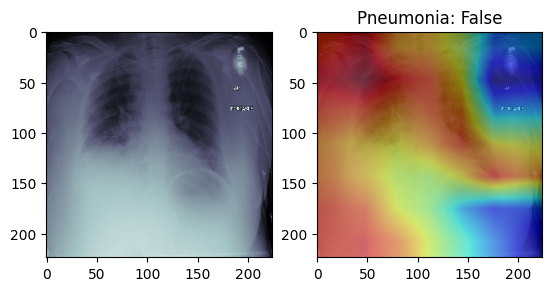

In [40]:
idx = np.random.randint(0, len(val_dataset), (1,))

img = val_dataset[idx[0]][0].to(device)  # Select a subject

activation_map, pred = cam(modelcam, img)
visualize(img.cpu(), activation_map, pred)